# Contributions to global warming from individual greenhouse gases

Myles Allen -- myles.allen@ouce.ox.ac.uk

The following notebook calculates contributions to global temperature increase due to individual greenhouse gas emissions as reported in the Primap database Gütschow, J.; Günther, A.; Jeffery, L.; Gieseke, R. (2021): The PRIMAP-hist national historical emissions time series (1850-2018). v2.2. zenodo. https://doi.org/10.5281/zenodo.4479172

Calculations are all based on the linear response model documented in Myhre, G., D. Shindell, F.-M. Bréon, W. Collins, J. Fuglestvedt, J. Huang, D. Koch, J.-F. Lamarque, D. Lee, B. Mendoza, T. Nakajima, A. Robock, G. Stephens, T. Takemura and H. Zhang, 2013: Anthropogenic and Natural Radiative Forcing Supplementary Material. In: Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, Y. Xia, V. Bex and P.M. Midgley (eds.)]. Available from https://www.ipcc.ch/report/ar5/wg1/chapter-8sm-anthropogenic-and-natural-radiative-forcing-supplementary-material/ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rc('font', size=14) #controls default text size
#plt.rc('axes', titlesize=12) #fontsize of the title
#plt.rc('axes', labelsize=12) #fontsize of the x and y labels
#plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
#plt.rc('legend', fontsize=14) #fontsize of the legend
colors=['#d62728', '#1f77b4', '#2ca02c', 'black']

In [2]:
def EFmod(nyr,a):
    Fcal = np.zeros((nyr,nyr)) # create linear operator to convert emissions to forcing
    time = np.arange(nyr+1)    # extend time array to compute derivatives
    F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
    for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
        Fcal[i,0]=F_0[i+1]-F_0[i]
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Fcal[j:nyr,j]=Fcal[0:nyr-j,0]
    return Fcal

def FTmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert forcing to warming
    time=np.arange(nyr)+0.5    # shift time array to compute derivatives
    for j in [0,1]:            # loop over thermal response times using AR5 formula
        Tcal[:,0]=Tcal[:,0]+(a[j+10]/a[j+15])*np.exp(-time/a[j+15])
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal

def ETmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert emissions to warming
    time=np.arange(nyr)+1      # add one to the time array for consistency with AR5 formulae
    for j in [0,1]:            # loop over thermal response times using AR5 formula for AGTP
        Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[0]*a[j+10]*(1-np.exp(-time/a[j+15]))
        for i in [1,2,3]:      # loop over gas decay terms using AR5 formula for AGTP
            Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[i]*a[i+5]*a[j+10]*(np.exp(-time/a[i+5])-np.exp(-time/a[j+15]))/(a[i+5]-a[j+15])      
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal


In [3]:
# first set up AR5 model parameters, using syntax of FaIRv1.3 but units of GtCO2, not GtC
ny2=251
tim2=np.arange(ny2)+1

m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
m_air=28.97*10**-3  # AR5 official molar mass of air
m_car=12.01*10**-3  # AR5 official molar mass of carbon
m_co2=44.01*10**-3  # AR5 official molar mass of CO2
m_ch4=16.043*10**-3 # AR5 official molar mass of methane
m_n2o=44.013*10**-3 # AR5 official molar mass of nitrous oxide

scl=1*10**3
a_ar5=np.zeros(20)

# Set to AR5 Values for CO2
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863] #AR5 carbon cycle coefficients
a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)      # old value = 0.471 ppm/GtC # convert GtCO2 to ppm
a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]    #AR5 carbon cycle timescales
a_ar5[10:12] = [0.631,0.429]                   #AR5 thermal sensitivity coeffs
a_ar5[13] = 1.37e-2                            #AR5 rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]                   #AR5 thermal time-constants -- could use Geoffroy et al [4.1,249.] 
a_ar5[18:21] = 0

ECS=3.0
a_ar5[10:12] *= ECS/np.sum(a_ar5[10:12])/3.7   # Rescale thermal sensitivity coeffs to prescribed ECS

# Set to AR5 Values for CH4
a_ch4=a_ar5.copy()
a_ch4[0:4]=[0,1.0,0,0]
a_ch4[4]=1.e12*1.e9/m_ch4/(m_atm/m_air)        # convert GtCH4 to ppb
a_ch4[5:9]=[1,12.4,1,1]                        # methane lifetime
a_ch4[13]=1.65*3.6324360e-4                    # Adjusted radiative efficiency in W/m2/ppb

# Set to AR5 Values for N2O
a_n2o=a_ar5.copy()
a_n2o[0:4]=[0,1.0,0,0]
a_n2o[4]=1.e12*1.e9/m_n2o/(m_atm/m_air)        # convert GtN2O to ppb
a_n2o[5:9]=[1,121.,1,1]                        # N2O lifetime
a_n2o[13]=(1.-0.36*1.65*3.63e-4/3.0e-3)*3.0e-3 # Adjusted radiative efficiency in W/m2/ppb

In [4]:
# compute operators to convert emissions to forcing for CO2 and CH4
Fco2 = EFmod(ny2,a_ar5) # emissions to forcing for CO2
Fch4 = EFmod(ny2,a_ch4) # emissions to forcing for CH4
Tco2 = ETmod(ny2,a_ar5) # emissions to temperature for CO2
Tch4 = ETmod(ny2,a_ch4) # emissions to temperature for CH4
Fco2inv = np.linalg.inv(Fco2) # forcing to emissions for CO2
Fch4inv = np.linalg.inv(Fch4) # forcing to emissions for CH4

In [5]:
# create 1 GtCO2 or GtCH4 pulse & constant emissions
E1=np.zeros([ny2,2])
E1[0,0]=1.
E1[:,1]=np.ones(ny2)

Total EU28 emissions since 1850 using methane gwp 28.0 483.0298153857337
Total EU28 emissions since 1850 using methane gwp 28.0 52.753108999999995
Total EU28 emissions since 1990 using methane gwp 28.0 143.8623789
Total EU28 emissions since 1990 using methane gwp 28.0 13.503445


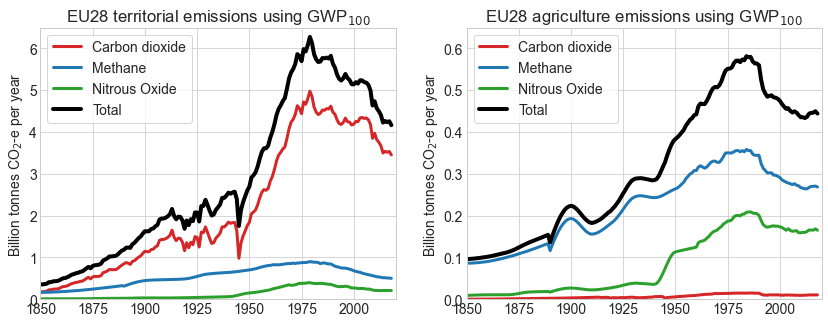

In [6]:
PR_input = pd.read_csv('PRIMAP-hist_v2.2_19-Jan-2021.csv')
PR_country = 'EU28'
PR_category = ['IPC1','IPC2','IPCMAG','IPC4']
PR_entity = ['CO2','CH4','N2O']
PR_scenario = 'HISTCR'
gwp=np.array([1.,28.,265.])
labels=['Carbon dioxide','Methane','Nitrous Oxide','Total']

PR_year=np.arange(2018-1850+1)+1850
PR_ghgs=np.zeros([2018-1850+1,4,3])
PR_co2e=np.zeros([2018-1850+1,4,3])
for j in range(0,3):
    for i in range(0,4):
        selection = PR_input[(PR_input.country == PR_country)&(PR_input.category == PR_category[i])&\
                             (PR_input.entity == PR_entity[j])&(PR_input.scenario == PR_scenario)]
        individual_timeseries = selection[selection.scenario == PR_scenario].transpose()
        PR_ghgs[:,i,j] = individual_timeseries.loc['1850':].values.squeeze()/1e6
        PR_co2e[:,i,j] = individual_timeseries.loc['1850':].values.squeeze()/1e6*gwp[j]
yrange=np.array([[0,6.5],[0,0.65]])        
fig = plt.figure(figsize=(14,5))        
ax = fig.add_subplot(121)
ax.axes.set_xlim([1850,2020])
ax.axes.set_ylim(yrange[0,:])
ax.set_ylabel('Billion tonnes CO$_2$-e per year')
ax.set_title('EU28 territorial emissions using GWP$_{100}$')
for j in range(0,3):
    ax.plot(PR_year,np.sum(PR_co2e[:,:,j],axis=1), color=colors[j], label=labels[j], linewidth=3)
ax.plot(PR_year,np.sum(PR_co2e[:,:,:],axis=(1,2)), color=colors[3], label='Total', linewidth=4)
ax.legend(frameon=True)
ax = fig.add_subplot(122)
ax.axes.set_xlim([1850,2020])
ax.axes.set_ylim(yrange[1,:])
ax.set_ylabel('Billion tonnes CO$_2$-e per year')
ax.set_title('EU28 agriculture emissions using GWP$_{100}$')
for j in range(0,3):
    ax.plot(PR_year,PR_co2e[:,2,j], color=colors[j], label=labels[j], linewidth=3)
ax.plot(PR_year,np.sum(PR_co2e[:,2,:],axis=1), color=colors[3], label='Total', linewidth=4)
ax.legend(frameon=True)
fig.savefig("EU28_emissions.png",dpi=300)
print('Total EU28 emissions since 1850 using methane gwp',gwp[1],np.sum(PR_co2e))
print('Total EU28 emissions since 1850 using methane gwp',gwp[1],np.sum(PR_co2e[:,2,:]))
print('Total EU28 emissions since 1990 using methane gwp',gwp[1],np.sum(PR_co2e[np.where(PR_year >= 1990),:,:]))
print('Total EU28 emissions since 1990 using methane gwp',gwp[1],np.sum(PR_co2e[np.where(PR_year >= 1990),2,:]))



In [7]:
ny3=np.shape(PR_year)[0]
Fco2 = EFmod(ny3,a_ar5) # emissions to forcing for CO2
Fch4 = EFmod(ny3,a_ch4) # emissions to forcing for CH4
Fn2o = EFmod(ny3,a_n2o) # emissions to forcing for N2O
Tco2 = ETmod(ny3,a_ar5) # emissions to temperature for CO2
Tch4 = ETmod(ny3,a_ch4) # emissions to temperature for CH4
Tn2o = ETmod(ny3,a_n2o) # emissions to temperature for N2O
Fco2inv = np.linalg.inv(Fco2) # forcing to emissions for CO2
E1=np.zeros([ny3,2])
E1[0,0]=1.
E1[:,1]=np.ones(ny3)
# Compute forcing response
F1C=Fco2@E1
F1M=Fch4@E1
F1N=Fn2o@E1
# Calculate GWP_P and GWP_S
GWP_M=F1M/F1C
GWP_N=F1N/F1C
print('CH4 GWP20 & 100',GWP_M[[19,99],1] )
print('N2O GWP20 & 100',GWP_N[[19,99],1] )
# Compute temperature response
T1C=Tco2@E1
T1M=Tch4@E1
T1N=Tn2o@E1
# Calculate GTP_P and GTP_S
GTP_M=T1M/T1C
GTP_N=T1N/T1C
print('CH4 GTP20 & 100',GTP_M[[19,99],0] )
print('N2O GTP20 & 100',GTP_N[[19,99],0] )


CH4 GWP20 & 100 [83.64333008 28.40514574]
N2O GWP20 & 100 [262.98275058 264.05369631]
CH4 GTP20 & 100 [67.25156729  4.25941777]
N2O GTP20 & 100 [275.96382574 233.41175836]


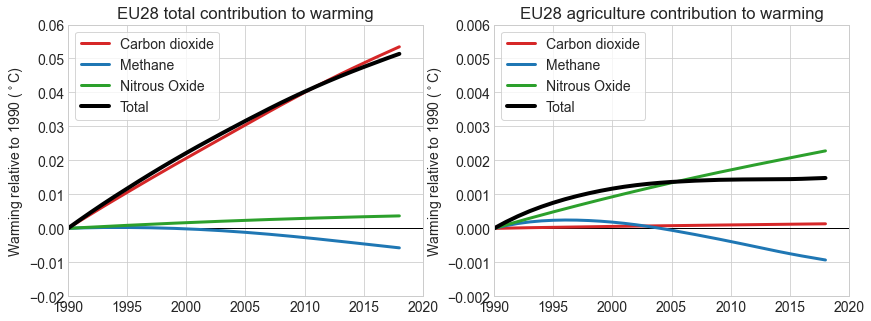

In [9]:
PR_temp=np.zeros([2018-1850+1,4,3])
PR_zero=np.zeros_like(PR_temp)
PR_tc2e=np.zeros_like(PR_temp)
Wt_zero=np.ones_like(PR_year)
xrange=[1990,2020]
if xrange[0] <= 1900:
    yrange=np.array([[0,0.25],[0,0.025]])
    legloc=2.
else:
    yrange=np.array([[-0.02,0.06],[-0.002,0.006]])
    legloc=2.
    Wt_zero[np.where(PR_year > xrange[0])]=0.
for i in range(0,4):
    PR_temp[:,i,0]=Tco2@PR_ghgs[:,i,0]
    PR_temp[:,i,1]=Tch4@PR_ghgs[:,i,1]
    PR_temp[:,i,2]=Tn2o@PR_ghgs[:,i,2]
    PR_tc2e[:,i,0]=Tco2@PR_co2e[:,i,0]
    PR_tc2e[:,i,1]=Tco2@PR_co2e[:,i,1]
    PR_tc2e[:,i,2]=Tco2@PR_co2e[:,i,2]
    PR_zero[:,i,0]=Tco2@(PR_ghgs[:,i,0]*Wt_zero)
    PR_zero[:,i,1]=Tch4@(PR_ghgs[:,i,1]*Wt_zero)
    PR_zero[:,i,2]=Tn2o@(PR_ghgs[:,i,2]*Wt_zero)
fig = plt.figure(figsize=(14,5))        
ax = fig.add_subplot(121)

ylabel='Warming relative to '+str(xrange[0])+' ($^\circ$C)'
ax.axes.set_xlim(xrange)
ax.axes.set_ylim(yrange[0,:])
for i in range(0,4):
    for j in range(0,3):
        PR_temp[:,i,j] -= np.squeeze(PR_temp[np.where(PR_year == xrange[0]),i,j])
        PR_zero[:,i,j] -= np.squeeze(PR_zero[np.where(PR_year == xrange[0]),i,j])
        PR_tc2e[:,i,j] -= np.squeeze(PR_tc2e[np.where(PR_year == xrange[0]),i,j])
ax.set_ylabel(ylabel)
ax.set_title('EU28 total contribution to warming')
ax.plot(xrange,[0,0],color='black', linewidth=1)
for j in range(0,3):
    line,=ax.plot(PR_year,np.sum(PR_temp[:,:,j],axis=1), color=colors[j], label=labels[j], linewidth=3)
#    ax.plot(PR_year,np.sum(PR_temp[:,[0,1,3],j],axis=1)+PR_zero[:,2,j],color = line.get_color(), linestyle = ':', linewidth=3)
line,=ax.plot(PR_year,np.sum(PR_temp[:,:,:],axis=(1,2)), color=colors[3], label='Total', linewidth=4)
#ax.plot(PR_year,np.sum(PR_tc2e[:,:,1],axis=1), color=colors[1] , linestyle = '--', linewidth=2, label='"CO$_2$-e" warming')
#ax.plot(PR_year,np.sum(PR_temp[:,[0,1,3],:],axis=(1,2))+np.sum(PR_zero[:,2,:],axis=1),color = line.get_color(), linestyle = ':', linewidth=4, label='No ag. from 1990')
ax.legend(loc=legloc,frameon=True)
ax = fig.add_subplot(122)
ax.axes.set_xlim(xrange)
ax.axes.set_ylim(yrange[1,:])
ax.axes.set_ylabel(ylabel)
ax.set_title('EU28 agriculture contribution to warming')
ax.plot(xrange,[0,0],color='black', linewidth=1)
for j in range(0,3):
    line,=ax.plot(PR_year,PR_temp[:,2,j], color=colors[j], label=labels[j], linewidth=3)
#    ax.plot(PR_year,PR_zero[:,2,j], color=colors[j] , linestyle = ':', linewidth=3)
line,=ax.plot(PR_year,np.sum(PR_temp[:,2,:],axis=1), color=colors[3], label='Total', linewidth=4)
#ax.plot(PR_year,PR_tc2e[:,2,1], color=colors[1] , linestyle = '--', linewidth=2, label='"CO$_2$-e" warming')
#ax.plot(PR_year,np.sum(PR_zero[:,2,:],axis=1),color=colors[3], linestyle = ':', linewidth=4, label='No ag. from 1990')
ax.legend(loc=legloc,frameon=True)
fig.savefig('EU28_warming'+str(xrange[0])+'expanded.png',dpi=300)